         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

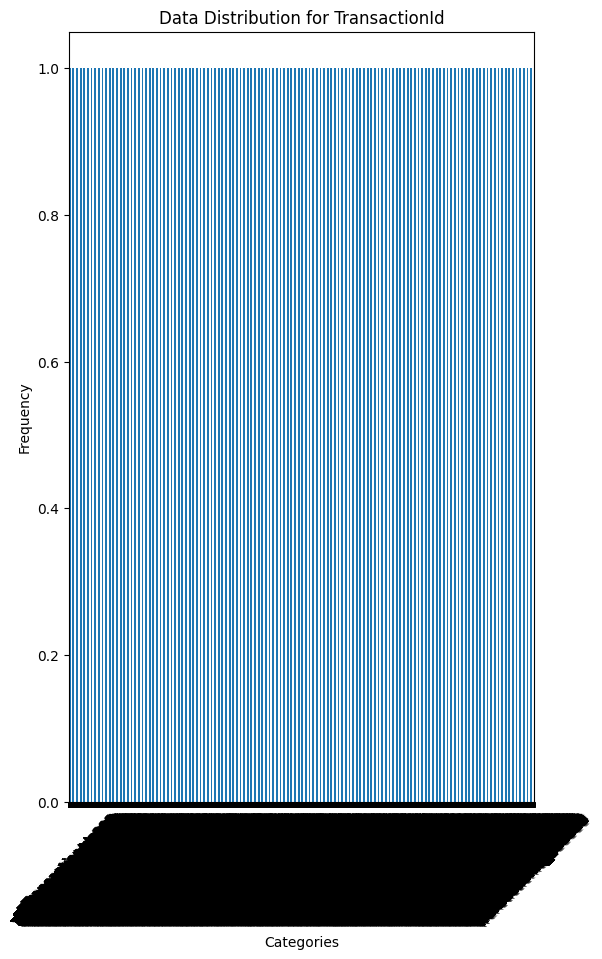

In [ ]:
%run EDA.ipynb

In [10]:
print(framed_data.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId       Amount        Value  Pricin

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming framed_data is your dataframe
categorical_data = framed_data.select_dtypes(include='object').columns

# Use Label Encoding for high-cardinality columns
label_encoder = LabelEncoder()
for col in categorical_data:
    unique_values = framed_data[col].nunique()
    if unique_values > 100:  # Set a threshold for large cardinality
        framed_data[col] = label_encoder.fit_transform(framed_data[col])
    else:
        # Use one-hot encoding for lower cardinality columns
        framed_data = pd.get_dummies(framed_data, columns=[col], drop_first=True)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import woe

# Load your data (assuming framed_data is already defined)
# framed_data = pd.read_csv('your_data.csv')  # Uncomment if you need to load data

# Convert TransactionStartTime to datetime
framed_data['TransactionStartTime'] = pd.to_datetime(framed_data['TransactionStartTime'])


In [ ]:
# Calculate Recency (R)
latest_transaction = framed_data['TransactionStartTime'].max()
framed_data['Recency'] = (latest_transaction - framed_data['TransactionStartTime']).dt.days

# Calculate Frequency (F)
frequency = framed_data.groupby('CustomerId')['TransactionId'].count().reset_index()
frequency.columns = ['CustomerId', 'Frequency']

# Calculate Monetary Value (M)
monetary = framed_data.groupby('CustomerId')['Amount'].sum().reset_index()
monetary.columns = ['CustomerId', 'Monetary']

# Merge the RFMS data
rfm = pd.merge(frequency, monetary, on='CustomerId')
rfm = pd.merge(rfm, framed_data[['CustomerId', 'Recency']].drop_duplicates(), on='CustomerId')

# Define Subscription score (S)
subscription = framed_data.groupby('CustomerId')['ProductCategory'].nunique().reset_index()
subscription.columns = ['CustomerId', 'Subscription']
rfms = pd.merge(rfm, subscription, on='CustomerId')

# Display RFMS DataFrame
print(rfms.head())


In [ ]:
# Scale RFMS values
scaler = StandardScaler()
rfms_scaled = scaler.fit_transform(rfms[['Recency', 'Frequency', 'Monetary', 'Subscription']])

# Use KMeans clustering to classify users into "good" and "bad"
kmeans = KMeans(n_clusters=2, random_state=42)  # 2 clusters
rfms['Cluster'] = kmeans.fit_predict(rfms_scaled)

# Assign labels based on the cluster
rfms['Label'] = rfms['Cluster'].map({0: 'Bad', 1: 'Good'})  # Adjust if necessary


In [ ]:
# Example of WoE binning for Recency
binning = woe.Binning(column='Recency', target='Label', qcut_binning=True)
train_woe = binning.fit_transform(rfms)

# You can repeat this for other columns as needed


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot RFMS Clusters
sns.pairplot(rfms, hue='Label', vars=['Recency', 'Frequency', 'Monetary', 'Subscription'])
plt.title("RFMS Clustering Results")
plt.show()
